In [1]:
import numpy as np
import tensorflow as tf
#this posiibly slows donw my shit significantly
# tf.config.run_functions_eagerly(True)
import pywt
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from MyEDFImports import load_all_data, import_ecg, get_edf_filenames, load_all_labels

2023-06-06 13:08:16.287333: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-06 13:08:16.863010: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data = load_all_data()
labels = load_all_labels()

Extracting EDF parameters from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers/CP229110.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers/WD224010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers/TK221110.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers/VP214110.edf...
EDF file detected
Setting chann

/home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/MyEDFImports.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'CHIN EMG'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + "//" + name)
/home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/MyEDFImports.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'CHIN EMG'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + "//" + name)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers/LM230010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers/VC209100.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers/LA216100.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_

In [3]:
from collections import Counter

counted_labels = Counter(labels)
counted_labels

Counter({0: 3519, 1: 1127, 2: 8844, 3: 975, 5: 3473, 4: 1310})

In [4]:
def three_stages_transform(n: int):
    if n == 0:
        return 0
    if n == 5:
        return 2
    return 1


labels_3_stages = np.array(list(map(three_stages_transform, labels)))
counted_labels_3_stages = Counter(labels_3_stages)
counted_labels_3_stages

Counter({0: 3519, 1: 12256, 2: 3473})

My first CNN model from https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/

In [5]:
train_size = 4000
test_size = 400

import keras
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import History

history = History()

img_x = 127
img_y = 127
img_z = 1
input_shape = (img_x, img_y, img_z)

batch_size = 16
num_classes = 3
epochs = 10


In [6]:
shuffle = np.random.shuffle(np.arange(len(data)))
data_shuffled = data[shuffle]
labels_shuffled = labels[shuffle]
labels_3_stages_shuffled = labels_3_stages[shuffle]

In [7]:
scales = range(1, 128)
waveletname = 'morl'

In [8]:

train_data_cwt = np.ndarray(shape=(train_size, 127, 127))
test_data_cwt = np.ndarray(shape=(test_size, 127, 127))

for ii in range(0, train_size):
    if ii % 1000 == 0:
        print(ii)
    signal = data[ii]
    coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
    coeff_ = coeff[:, :127]
    train_data_cwt[ii] = coeff_



0
1000
2000
3000


In [9]:
for ii in range(0, test_size):
    if ii % 100 == 0:
        print(ii)
    signal = data[ii]
    coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
    coeff_ = coeff[:, :127]
    test_data_cwt[ii] = coeff_

0
100
200
300


In [10]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

2023-06-06 13:26:26.915655: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-06 13:26:26.933839: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-06 13:26:26.934031: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 123, 123, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 61, 61, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 1000)              5

In [12]:
x_train = train_data_cwt
x_test = test_data_cwt
y_train = labels_3_stages[:train_size]
y_test = labels_3_stages[-test_size:]

y_train = keras.utils.to_categorical(y_train,num_classes)
y_test = keras.utils.to_categorical(y_test,num_classes)

In [13]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[history])


Epoch 1/10


2023-06-06 13:26:29.700639: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2023-06-06 13:26:30.616093: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-06 13:26:30.617127: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-06 13:26:30.617147: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Couldn't invoke ptxas --version
2023-06-06 13:26:30.618218: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-06 13:26:30.618262: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:317] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This mes

250/250 [==============================] - 7s 13ms/step - loss: 0.9698 - accuracy: 0.5393 - val_loss: 1.0033 - val_accuracy: 0.6775
Epoch 2/10
250/250 [==============================] - 3s 12ms/step - loss: 0.9606 - accuracy: 0.5490 - val_loss: 0.9688 - val_accuracy: 0.6775
Epoch 3/10
250/250 [==============================] - 3s 12ms/step - loss: 0.9607 - accuracy: 0.5490 - val_loss: 0.9727 - val_accuracy: 0.6775
Epoch 4/10
250/250 [==============================] - 3s 12ms/step - loss: 0.9580 - accuracy: 0.5490 - val_loss: 0.9670 - val_accuracy: 0.6775
Epoch 5/10
250/250 [==============================] - 3s 12ms/step - loss: 0.9570 - accuracy: 0.5490 - val_loss: 0.9740 - val_accuracy: 0.6775
Epoch 6/10
250/250 [==============================] - 3s 12ms/step - loss: 0.9565 - accuracy: 0.5490 - val_loss: 0.9780 - val_accuracy: 0.6775
Epoch 7/10
250/250 [==============================] - 3s 12ms/step - loss: 0.9573 - accuracy: 0.5490 - val_loss: 0.9721 - val_accuracy: 0.6775
Epoch 8/10

In [14]:
train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

Train loss: 0.9558569192886353, Train accuracy: 0.5490000247955322
Test loss: 0.9548448920249939, Test accuracy: 0.6775000095367432


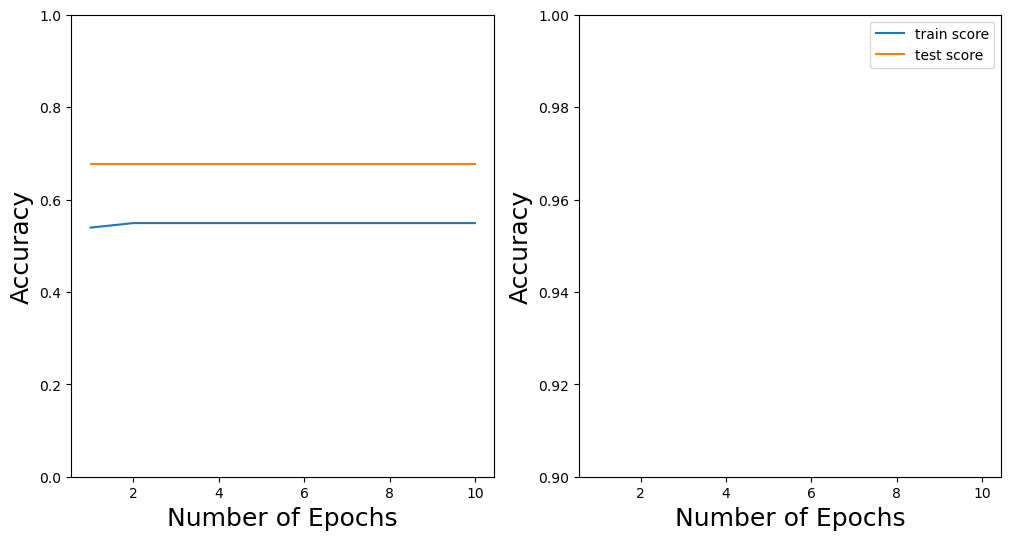

In [16]:
fig, axarr = plt.subplots(figsize=(12,6), ncols=2)
axarr[0].plot(range(1, 11), history.history['accuracy'], label='train score')
axarr[0].plot(range(1, 11), history.history['val_accuracy'], label='test score')
axarr[0].set_xlabel('Number of Epochs', fontsize=18)
axarr[0].set_ylabel('Accuracy', fontsize=18)
axarr[0].set_ylim([0,1])
axarr[1].plot(range(1, 11), history.history['accuracy'], label='train score')
axarr[1].plot(range(1, 11), history.history['val_accuracy'], label='test score')
axarr[1].set_xlabel('Number of Epochs', fontsize=18)
axarr[1].set_ylabel('Accuracy', fontsize=18)
axarr[1].set_ylim([0.9,1])
plt.legend()
plt.show()

In [17]:
history.history

{'loss': [0.969843327999115,
  0.9606369137763977,
  0.9606726169586182,
  0.9580044150352478,
  0.9570040702819824,
  0.9565365314483643,
  0.9572973847389221,
  0.9557863473892212,
  0.9552872180938721,
  0.9555025100708008],
 'accuracy': [0.5392500162124634,
  0.5490000247955322,
  0.5490000247955322,
  0.5490000247955322,
  0.5490000247955322,
  0.5490000247955322,
  0.5490000247955322,
  0.5490000247955322,
  0.5490000247955322,
  0.5490000247955322],
 'val_loss': [1.0032552480697632,
  0.9687631130218506,
  0.97272127866745,
  0.9669603109359741,
  0.9740071296691895,
  0.9779520630836487,
  0.9721001386642456,
  0.9677794575691223,
  0.9648762345314026,
  0.954845130443573],
 'val_accuracy': [0.6775000095367432,
  0.6775000095367432,
  0.6775000095367432,
  0.6775000095367432,
  0.6775000095367432,
  0.6775000095367432,
  0.6775000095367432,
  0.6775000095367432,
  0.6775000095367432,
  0.6775000095367432]}

In [ ]:
test_data_cwt